In [92]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import math
pd.set_option("display.max_rows", None)
# np.random.seed(seed=1903)

In [93]:
def numrelu(x, breaks):
    centers = np.linspace(0, 1, breaks).tolist()
    return np.vstack([[1]*x.shape[0], np.array([(x-c)*(x>c) for c in centers])]).T

In [94]:
def numpoly(x, degree):
    # TODO: Fix. There is no need to add a column of ones because the first colun of x**0 is a column of ones.
    return np.vstack([[1]*x.shape[0], np.array([t**c for c in range(degree)])]).T

In [95]:
def numstep(x, breaks):
    centers = np.linspace(0, 1, breaks).tolist()
    # TODO: Fix. There is no need to have a column of ones in the beginning for this basis, let alone two.
    return np.vstack([[1]*x.shape[0], [1]*x.shape[0], np.array([np.piecewise(x, [(x >= centers[i]) & (x < centers[i+1])], [1., 0.]) for i in range(breaks-1)])]).T

In [96]:
def numbsplines(x, centers):
    # TODO: Implement
    pass

In [97]:
def reconstruct_function(x, w_x):
    return np.sum((x * w_x).T, axis=0)

In [98]:
def gen_random_design(dims, a=-1, b=1):
    experiments = dims[0]
    features = dims[1]
    df = pd.DataFrame((b - a)*np.random.random((experiments, features)) + a) # random uniform [-1,1]
    df.columns = ['w' + str(x) for x in list(range(features))]
    return df

In [99]:
def gen_model_matrix(data, J_mat):
    J_cgb = data @ J_mat
    Z_mat = np.append(np.array([1]*J_cgb.shape[0]).reshape((-1,1)), J_cgb, axis=1)
    return Z_mat

In [109]:
t_detail = 100
w_detail = 3

n_exp = 4
x_breaks = 16
b_brakes = 16

t = np.linspace(0, 1, t_detail)
dt = t[1] - t[0]

w_levels = {}
for i in range(x_breaks + 1):
    w_levels[i] = np.linspace(-1, 1, w_detail).tolist()

# Define basis and centers
# c_t = numrelu(x=t, breaks=x_breaks)
# c_t = numpoly(x=t, degree=x_breaks)
c_t = numstep(x=t, breaks=x_breaks)
c_bas = 'numstep'
# b_t = numstep(x=t, breaks=b_brakes)
b_t = numpoly(x=t, degree=1)
J_cb = np.cumsum((c_t.T @ b_t)/t_detail, axis=1) * dt # Calculate Integral of basis matrix
J_cb.shape

(17, 2)

In [110]:
def clear_histories(optimalities, designs, design_mat):
    hstry_designs = pd.DataFrame(designs, columns=['epoch', *list(design_mat.columns)])
    hstry_opt_cr = pd.DataFrame(optimalities).rename(columns={0: 'epoch',
                                                              1: 'experiment',
                                                              2: 'weight'})
    hstry_opt_cr['max'] = hstry_opt_cr.iloc[:, 3:].max(axis=1)
    return hstry_designs, hstry_opt_cr

In [111]:
def find_best_design(histories, designs, max_bool=True):
    if max_bool:
        per_epoch = histories.groupby('epoch')['max'].max()
        return designs[designs['epoch'] == per_epoch.idxmax()].reset_index().iloc[:, 2:]
    else:
        per_epoch = histories.groupby('epoch')['min'].min()
        return designs[designs['epoch'] == per_epoch.idxmin()].reset_index().iloc[:, 2:]

In [112]:
hstry_opt_cr = []
hstry_designs = np.array([]).reshape((0, x_breaks + 1 + 1))
epochs = 1000

for epoch in tqdm(range(epochs)):
    design_matrix = gen_random_design((n_exp, x_breaks + 1)) # Start with random design matrix
    for exp in range(n_exp):
        for weight in range(x_breaks+1):
            coordinate_opt_cr = []
            for _, level in enumerate(w_levels[weight]):
                design_matrix.iat[exp, weight] = level
                model_matrix = gen_model_matrix(data=design_matrix, J_mat=J_cb)
                # Calculate Criterion
                engine = np.linalg.det(model_matrix.T @ model_matrix)
                # engine = np.trace(model_matrix.T @ model_matrix)
                coordinate_opt_cr.append(engine)

            hstry_opt_cr.append([epoch, exp, weight, *coordinate_opt_cr])
            # Change W matrix in order to maximize d_opt_criterion
            design_matrix.iat[exp, weight] = w_levels[weight][coordinate_opt_cr.index(max(coordinate_opt_cr))]

        # clean results of inner loop
        hstry_designs = np.append(hstry_designs,
                                  np.hstack((np.array([epoch] * n_exp).reshape(-1, 1),
                                             np.array(design_matrix))),
                                  axis=0)

hstry_designs, hstry_opt_cr = clear_histories(optimalities=hstry_opt_cr, designs=hstry_designs, design_mat=design_matrix)
best_design = find_best_design(histories=hstry_opt_cr, designs=hstry_designs)
model_matrix=gen_model_matrix(data=best_design, J_mat=J_cb)
best_design

100%|██████████| 1000/1000 [12:28<00:00,  1.34it/s]


,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15,w16
0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,0.770305,0.942019,-0.956518,-0.068899,-0.468573,-0.459089,0.629592,-0.503536,-0.089780,0.258334,0.124154,-0.817796,-0.470888,-0.642962,0.985551,0.133685,0.627633
2,-0.020055,0.683140,-0.207839,-0.967957,0.197259,-0.874478,-0.273015,-0.259533,-0.914676,0.525783,-0.133214,-0.793629,0.984775,-0.722437,-0.471371,-0.238019,0.677527
3,0.374346,-0.540071,0.782528,0.951965,0.568488,0.950349,-0.859875,0.841698,0.540494,-0.166587,0.332273,0.754918,0.573879,0.119613,-0.822177,0.843663,0.086872
4,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
5,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
6,-0.020055,0.683140,-0.207839,-0.967957,0.197259,-0.874478,-0.273015,-0.259533,-0.914676,0.525783,-0.133214,-0.793629,0.984775,-0.722437,-0.471371,-0.238019,0.677527
7,0.374346,-0.540071,0.782528,0.951965,0.568488,0.950349,-0.859875,0.841698,0.540494,-0.166587,0.332273,0.754918,0.573879,0.119613,-0.822177,0.843663,0.086872
8,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
9,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [113]:
if c_bas == 'numrelu':
    for _ in range(1, x_breaks + 1):
        design_matrix[f'w{_}_scaled'] = 2 / (x_breaks + 1) * (design_matrix[f'w{_}'] - design_matrix['w0'])
    design_matrix_scaled = design_matrix[['w0', *[f'w{i}_scaled' for i in range(1, x_breaks + 1)]]]
elif c_bas in ['numpoly', 'numstep']:
    design_matrix_scaled = design_matrix[['w0', *[f'w{i}' for i in range(1, x_breaks + 1)]]]

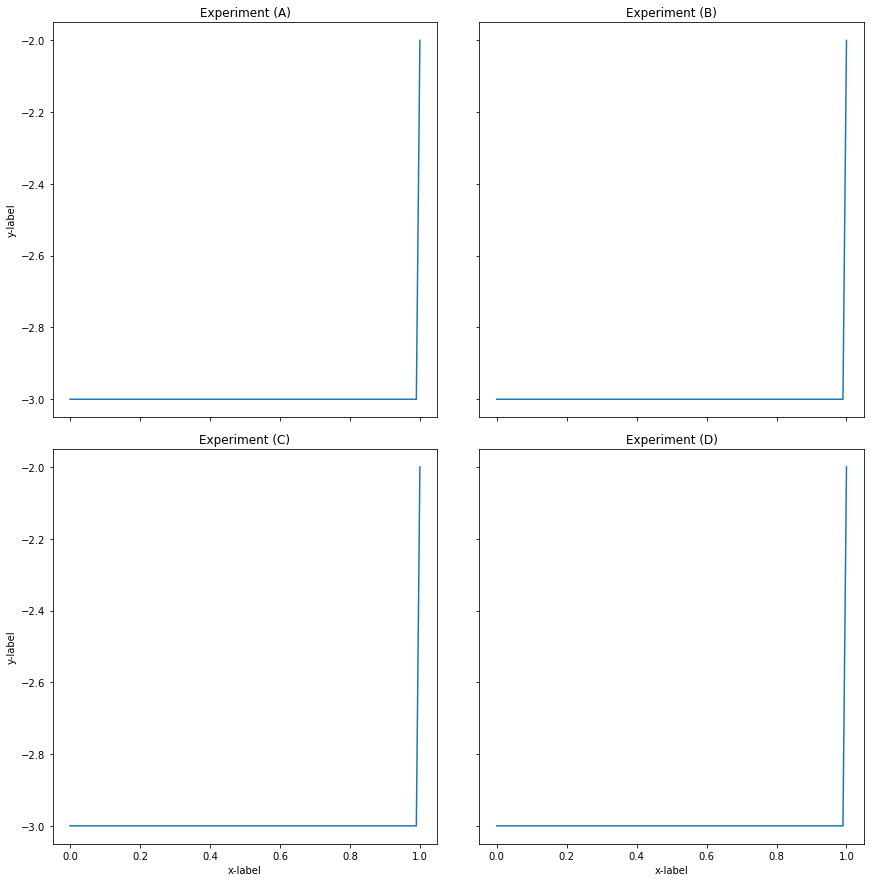

In [114]:
rows = math.ceil(n_exp/2)
cols = 2
fig, axs = plt.subplots(rows,cols, figsize=(12,12))
fig.tight_layout()
n=0
for i in range(rows):
    for j in range(cols):
        try:
            axs[i, j].plot(t, reconstruct_function(c_t, np.array(design_matrix_scaled.iloc[n, :]).reshape((-1,1)).T))
            axs[i, j].set_title(f'Experiment ({chr(65 + n)})')
            n += 1
        except:
            pass

for ax in axs.flat:
    ax.set_xlabel('x-label')
    ax.set_ylabel('y-label')
    if c_bas == 'numrelu':
        ax.set_xlim([-0.05, 1.05])
        ax.set_ylim([-1.2, 1.2])

for ax in axs.flat:
    ax.label_outer()

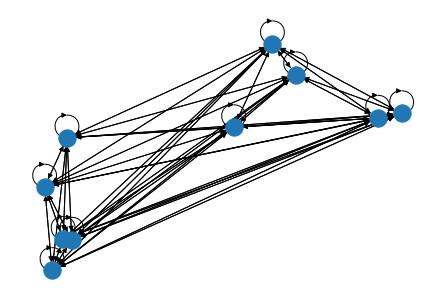

In [123]:
# check if two designs are the same with graph isomorphism.
# We are using their information matrix as an adjacency matrix to calculate isomorphism.
import networkx as nx
X1 = gen_random_design((50,10))
cols = list(X1.columns)
cols = [cols[-1]] + cols[:-1]
X2 = X1[cols]
G1 = nx.DiGraph((X1.T @ X1).values)
G2 = nx.DiGraph((X2.T @ X2).values)

nx.draw(G1)

In [122]:
nx.is_isomorphic(G1, G2)

True

In [121]:
X2

,w9,w0,w1,w2,w3,w4,w5,w6,w7,w8
0,-0.732413,0.492652,-0.548183,-0.546150,0.346314,0.035683,-0.316169,-0.142422,-0.135926,-0.355396
1,-0.663739,-0.841593,0.187121,-0.021082,-0.128459,0.586064,0.739667,0.274564,-0.306916,-0.726857
2,-0.792292,0.076166,-0.516124,0.319306,-0.488180,0.376336,-0.011502,0.000357,-0.398380,-0.293549
3,-0.612935,-0.111511,0.338221,-0.646129,-0.676524,-0.601886,-0.811249,-0.146125,-0.856753,-0.764106
4,-0.483524,0.258726,-0.831068,0.189023,0.010542,0.563704,-0.113285,0.249763,0.369142,-0.012840
5,0.037439,-0.676418,0.783702,0.726983,0.487829,0.447392,0.413420,0.202354,0.191934,0.047119
6,-0.489345,-0.652955,0.267248,-0.594218,0.175221,0.816826,-0.690787,-0.392592,0.896873,-0.505609
7,0.260245,0.499568,0.891478,0.405419,0.579166,-0.999954,0.158071,0.326078,0.593272,-0.443863
8,0.162932,-0.676889,0.997789,-0.997348,0.074693,-0.851100,0.359675,-0.989246,0.370148,-0.504360
9,-0.932679,-0.033323,-0.660437,0.855813,0.359377,-0.823030,0.063227,-0.323570,0.361010,-0.200590
